In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlp import network
from dataloader import datasampler

# Data Loading

Data Source: http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

In [2]:
features = ['sex', 'length', 'diameter', 'height', 'weight', \
            'shuck_weight', 'visc_weight', 'shell_weight']
labels = ['rings']
intsex = {'M':0., 'F':1., 'I':2.}

In [3]:
data = pd.read_csv('data/abalone.data', names = features + labels)
data['sex'] = data['sex'].replace(intsex)
data.loc[(data['rings'] < 9), 'rings'] = 0
data.loc[(data['rings'] >= 9) & (data['rings'] <= 12), 'rings'] = 1
data.loc[(data['rings'] > 12), 'rings'] = 2
data.tail()

,sex,length,diameter,height,weight,shuck_weight,visc_weight,shell_weight,rings
4172,1.0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1
4173,0.0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,1
4174,0.0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1
4175,1.0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1
4176,0.0,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,1


# Data Visualization

In [4]:
def scatter(ax, data, xaxis, yaxis):
    X = np.array(data[[xaxis, yaxis]])
    Y = np.array(data["rings"])
    old = X[np.argwhere(Y==2)]
    middle = X[np.argwhere(Y==1)]
    young = X[np.argwhere(Y==0)]
    ax.scatter([s[0][0] for s in old], [s[0][1] for s in old], \
               s = 25, color = 'red', edgecolor = 'k')
    ax.scatter([s[0][0] for s in middle], [s[0][1] for s in middle], \
               s = 25, color = 'blue', edgecolor = 'k')
    ax.scatter([s[0][0] for s in young], [s[0][1] for s in young], \
               s = 25, color = 'green', edgecolor = 'k')
    ax.set_xlabel(xaxis)
    ax.set_ylabel(yaxis)

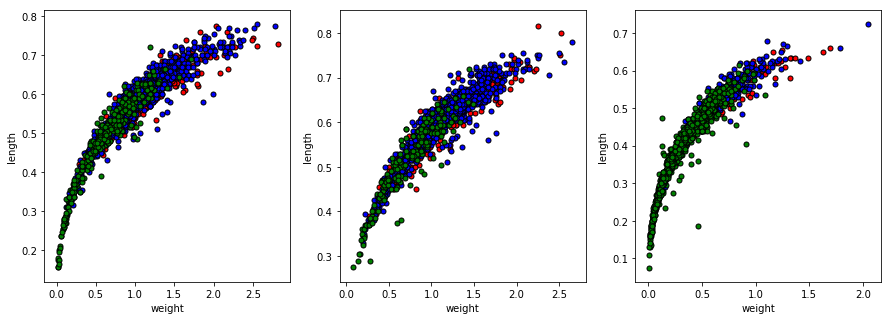

In [5]:
ncols = 3
fig, ax = plt.subplots(nrows=1, ncols=ncols)
fig.set_figwidth(15)
fig.set_figheight(5)
scatter(ax[0], data[data['sex'] == 0], 'weight', 'length')
scatter(ax[1], data[data['sex'] == 1], 'weight', 'length')
scatter(ax[2], data[data['sex'] == 2], 'weight', 'length')

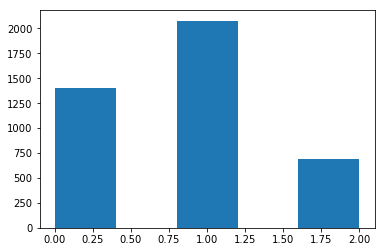

In [6]:
plt.hist(data['rings'], bins = 5)
pass;

# Data Pre-Processing

To demonstrate multi-category classifcation, we one-hot encode the admission variable

In [7]:
processed_data = pd.concat([data, pd.get_dummies(data['rings'], prefix='rings').astype(float)], axis=1)
processed_data = processed_data.drop('rings', axis=1)
labels = ['rings_0', 'rings_1', 'rings_2']

for x in features:
    processed_data.loc[:, x] *= np.divide(1, data[x].max())

processed_data.head()

,sex,length,diameter,height,weight,shuck_weight,visc_weight,shell_weight,rings_0,rings_1,rings_2
0,0.0,0.558282,0.561538,0.084071,0.181915,0.150874,0.132895,0.149254,0.0,0.0,1.0
1,0.0,0.429448,0.407692,0.079646,0.079809,0.066868,0.063816,0.069652,1.0,0.0,0.0
2,0.5,0.650307,0.646154,0.119469,0.239604,0.172379,0.186184,0.208955,0.0,1.0,0.0
3,0.0,0.539877,0.561538,0.110619,0.182623,0.144825,0.150000,0.154229,0.0,1.0,0.0
4,1.0,0.404908,0.392308,0.070796,0.072554,0.060148,0.051974,0.054726,1.0,0.0,0.0


Split the data into a training and a testing set. The size of the testing set will be 10% of the total data.

In [8]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
traindata, testdata = processed_data.iloc[sample], processed_data.drop(sample)
dimX, dimY = len(features), len(labels)

# Categorical Classification

In [9]:
np.random.seed(123)
model = network(dimX)
model.addlinear(4, activation = 'relu')
model.addlinear(4, activation = 'relu')
model.addlinear(4, activation = 'relu')
model.addlinear(dimY, activation = 'softmax')
model.layers

{1: [<mlp.linear at 0x7f73d5295e10>, <function mlp.relu(X)>, (8, 4)],
 2: [<mlp.linear at 0x7f73d52956d8>, <function mlp.relu(X)>, (4, 4)],
 3: [<mlp.linear at 0x7f73d52fbe48>, <function mlp.relu(X)>, (4, 4)],
 4: [<mlp.linear at 0x7f73d52953c8>, <function mlp.softmax(X)>, (4, 3)]}

In [10]:
nepoch = 10
printevery = 1

trainbatch = datasampler(traindata, features, labels, batchsize = 100)
testbatch = datasampler(testdata, features, labels, batchsize = 'all', shuffle = False)

for e in range(0, nepoch):
    epoch = trainbatch.nepoch
    
    while epoch == trainbatch.nepoch:
        Xtrain, Ytrain = trainbatch.getbatch()
    
        for X, Y in zip(Xtrain, Ytrain):
            model.forward(X, Y)
        model.backprop(0.01)
        
    if e%printevery ==0:
        trainloss = model.getloss()
        
        Xtest, Ytest = trainbatch.getbatch()
        
        for X, Y in zip(Xtest, Ytest):
            model.forward(X, Y)
        
        testloss = model.getloss()
        
        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f}'.format(
            e, trainloss, testloss))
    

Epoch: 0 	Train Loss: 0.443429 	Valid Loss: 0.397664
Epoch: 1 	Train Loss: 0.356259 	Valid Loss: 0.351285
Epoch: 2 	Train Loss: 0.341195 	Valid Loss: 0.340103
Epoch: 3 	Train Loss: 0.337811 	Valid Loss: 0.332311
Epoch: 4 	Train Loss: 0.336569 	Valid Loss: 0.344778
Epoch: 5 	Train Loss: 0.335815 	Valid Loss: 0.306961
Epoch: 6 	Train Loss: 0.337632 	Valid Loss: 0.319738
Epoch: 7 	Train Loss: 0.336335 	Valid Loss: 0.312548
Epoch: 8 	Train Loss: 0.337099 	Valid Loss: 0.336880
Epoch: 9 	Train Loss: 0.336028 	Valid Loss: 0.301561


# PyTorch Comparison

In [11]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict
from torch.utils.data import DataLoader

from dataloader import TabularDataset

In [12]:
torchmodel = nn.Sequential(OrderedDict([('fc1', nn.Linear(dimX, 4)),
                                        ('relu1', nn.ReLU()),
                                        ('fc2', nn.Linear(4, 4)),
                                        ('relu2', nn.ReLU()),
                                        ('fc3', nn.Linear(4, 4)),
                                        ('relu2', nn.ReLU()),
                                        ('output', nn.Linear(4, dimY))]))
# Define the loss

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(torchmodel.parameters(), lr=0.01)

print(torchmodel)

Sequential(
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)


In [13]:
trainset = TabularDataset(data=traindata, features=features, labels=labels)
testset = TabularDataset(data=testdata, features=features, labels=labels)

In [14]:
trainloader = DataLoader(trainset, batch_size = 100, shuffle=True, num_workers=1)
testloader = DataLoader(trainset, batch_size = len(testdata), shuffle=True, num_workers=1)

In [15]:
epochs = 10
batch_size = 100
print_every = 1

for e in range(epochs):
    trainloss = 0.0
    validloss = 0.0
    
    torchmodel.train()
    for iX, iY in trainloader:
        output = torchmodel.forward(iX)
        loss = criterion(output, iY)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainloss += loss.item()*iX.size(0)
        
    torchmodel.eval();
    with torch.no_grad():
        for iX, iY in testloader:
            output = torchmodel.forward(iX)
            vloss = criterion(output, iY)
            validloss += vloss.item()*iX.size(0)

        trainloss = trainloss/len(trainloader.dataset)
        validloss = validloss/len(testloader.dataset)

        if e%print_every == 0:
            print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f}'.format(
                e, trainloss, validloss))
pass;

Epoch: 0 	Train Loss: 0.622946 	Valid Loss: 0.572334
Epoch: 1 	Train Loss: 0.527577 	Valid Loss: 0.487497
Epoch: 2 	Train Loss: 0.476885 	Valid Loss: 0.469415
Epoch: 3 	Train Loss: 0.467857 	Valid Loss: 0.465814
Epoch: 4 	Train Loss: 0.463832 	Valid Loss: 0.462868
Epoch: 5 	Train Loss: 0.463530 	Valid Loss: 0.460457
Epoch: 6 	Train Loss: 0.461450 	Valid Loss: 0.458639
Epoch: 7 	Train Loss: 0.460601 	Valid Loss: 0.458282
Epoch: 8 	Train Loss: 0.459368 	Valid Loss: 0.456520
Epoch: 9 	Train Loss: 0.457052 	Valid Loss: 0.458840
